# Day_082

### 練習時間
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], drp_ratio = 0.2):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                                   activation = "relu", 
                                   name = "hidden_layer" + str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = Dense(units=n_units, 
                                   activation = "relu", 
                                   name = "hidden_layer" + str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.3, 0.5]

In [7]:
results = {}
for dropout_ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout Ratio = %.6f" % (dropout_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], drp_ratio = dropout_ratio)
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-drp_rate-%s" % str(dropout_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout Ratio = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None,

Epoch 49/50
50000/50000 [==============================] - 30s 609us/step - loss: 1.3541 - acc: 0.5187 - val_loss: 1.3320 - val_acc: 0.5229
Epoch 50/50
50000/50000 [==============================] - 31s 622us/step - loss: 1.3459 - acc: 0.5171 - val_loss: 1.3457 - val_acc: 0.5203
Experiment with Dropout Ratio = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)

Epoch 47/50
50000/50000 [==============================] - 31s 615us/step - loss: 1.6071 - acc: 0.4239 - val_loss: 1.4740 - val_acc: 0.4765
Epoch 48/50
50000/50000 [==============================] - 31s 619us/step - loss: 1.5916 - acc: 0.4302 - val_loss: 1.4817 - val_acc: 0.4716
Epoch 49/50
50000/50000 [==============================] - 31s 617us/step - loss: 1.5932 - acc: 0.4311 - val_loss: 1.4672 - val_acc: 0.4795
Epoch 50/50
50000/50000 [==============================] - 31s 623us/step - loss: 1.5839 - acc: 0.4322 - val_loss: 1.4661 - val_acc: 0.4736


In [8]:
def plt_model_result(result):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-loss'])), result[cond]['train-loss'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-loss'])), result[cond]['valid-loss'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-acc'])), result[cond]['train-acc'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-acc'])), result[cond]['valid-acc'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

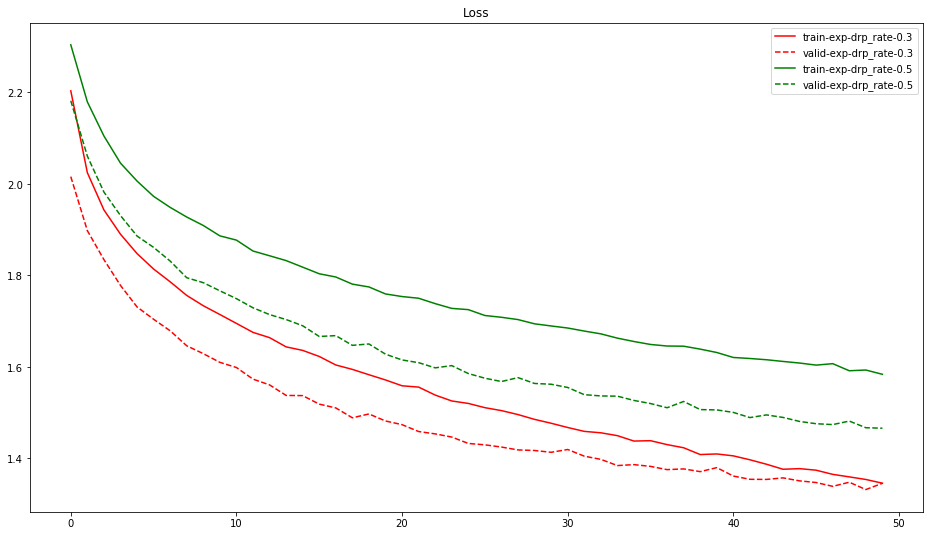

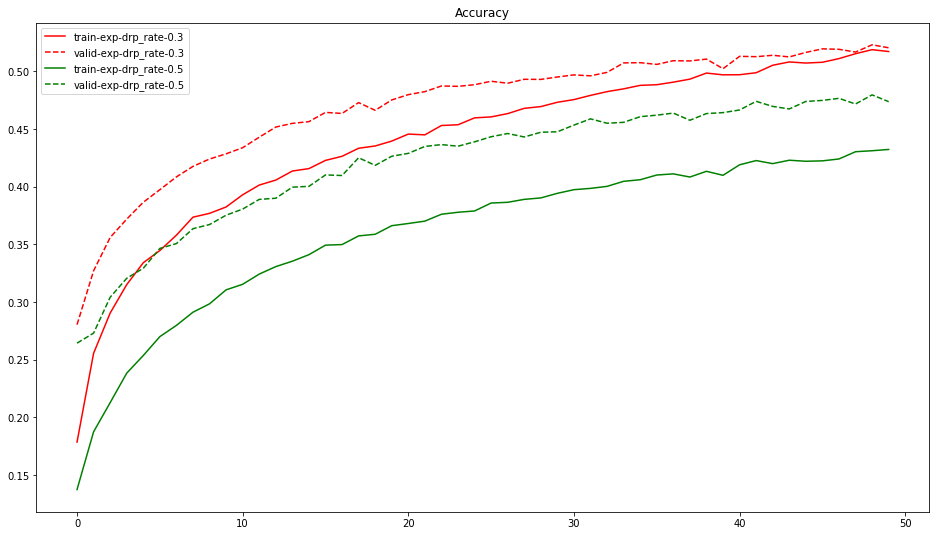

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt_model_result(results)

### 使用不同層數以及不同 Dropout rate

In [10]:
results = {}
for dropout_ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout Ratio = %.6f" % (dropout_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], num_neurons=[512, 256, 128, 64, 32], drp_ratio = dropout_ratio)
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-drp_rate-%s" % str(dropout_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout Ratio = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None,

50000/50000 [==============================] - 32s 646us/step - loss: 1.6138 - acc: 0.4123 - val_loss: 1.5187 - val_acc: 0.4521
Epoch 46/50
50000/50000 [==============================] - 32s 635us/step - loss: 1.6088 - acc: 0.4146 - val_loss: 1.5067 - val_acc: 0.4546
Epoch 47/50
50000/50000 [==============================] - 32s 638us/step - loss: 1.6030 - acc: 0.4182 - val_loss: 1.5091 - val_acc: 0.4561
Epoch 48/50
50000/50000 [==============================] - 31s 628us/step - loss: 1.5940 - acc: 0.4190 - val_loss: 1.5022 - val_acc: 0.4576
Epoch 49/50
50000/50000 [==============================] - 31s 627us/step - loss: 1.5955 - acc: 0.4202 - val_loss: 1.5067 - val_acc: 0.4556
Epoch 50/50
50000/50000 [==============================] - 32s 631us/step - loss: 1.5892 - acc: 0.4234 - val_loss: 1.4958 - val_acc: 0.4619
Experiment with Dropout Ratio = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

50000/50000 [==============================] - 31s 627us/step - loss: 1.9971 - acc: 0.2092 - val_loss: 1.9378 - val_acc: 0.2411
Epoch 40/50
50000/50000 [==============================] - 31s 630us/step - loss: 1.9884 - acc: 0.2071 - val_loss: 1.9386 - val_acc: 0.2451
Epoch 41/50
50000/50000 [==============================] - 31s 611us/step - loss: 1.9908 - acc: 0.2107 - val_loss: 1.9305 - val_acc: 0.2417
Epoch 42/50
50000/50000 [==============================] - 24s 486us/step - loss: 1.9873 - acc: 0.2128 - val_loss: 1.9376 - val_acc: 0.2464
Epoch 43/50
50000/50000 [==============================] - 31s 615us/step - loss: 1.9827 - acc: 0.2140 - val_loss: 1.9256 - val_acc: 0.2498
Epoch 44/50
50000/50000 [==============================] - 32s 637us/step - loss: 1.9817 - acc: 0.2123 - val_loss: 1.9324 - val_acc: 0.2443
Epoch 45/50
50000/50000 [==============================] - 32s 638us/step - loss: 1.9825 - acc: 0.2143 - val_loss: 1.9374 - val_acc: 0.2421
Epoch 46/50
50000/50000 [=======

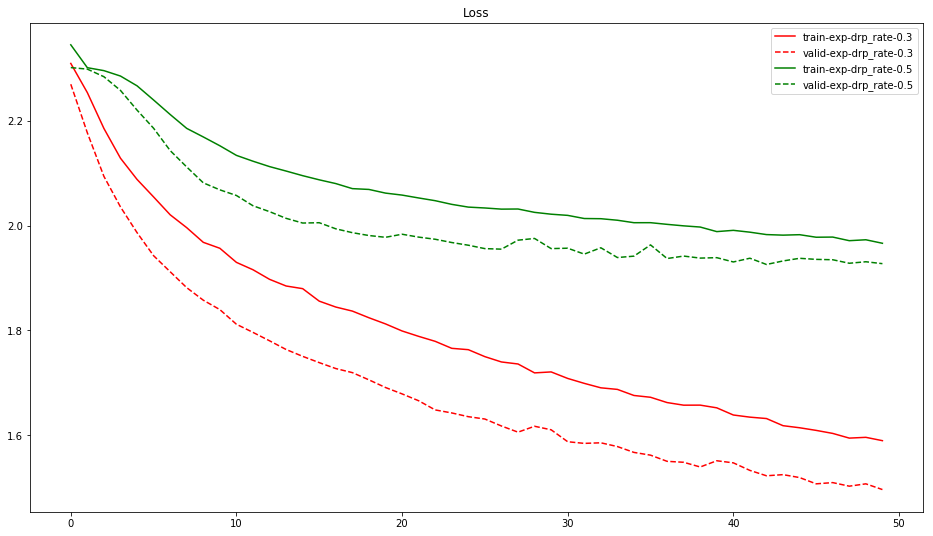

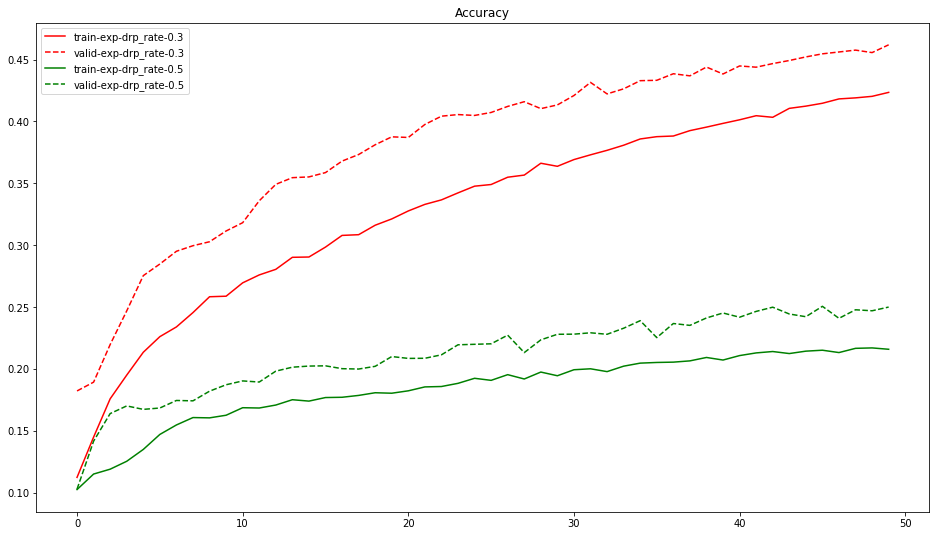

In [11]:
plt_model_result(results)

### 將 optimizer 改成使用 Adam

In [12]:
results = {}
for dropout_ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Dropout Ratio = %.6f" % (dropout_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], num_neurons=[512, 256, 128, 64, 32], drp_ratio = dropout_ratio)
    model.summary()
    optimizer = optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-drp_rate-%s" % str(dropout_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Dropout Ratio = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None,

50000/50000 [==============================] - 33s 668us/step - loss: 1.7966 - acc: 0.3433 - val_loss: 1.7563 - val_acc: 0.3686
Epoch 46/50
50000/50000 [==============================] - 33s 665us/step - loss: 1.7991 - acc: 0.3443 - val_loss: 1.7507 - val_acc: 0.3639
Epoch 47/50
50000/50000 [==============================] - 33s 665us/step - loss: 1.7974 - acc: 0.3428 - val_loss: 1.7796 - val_acc: 0.3619
Epoch 48/50
50000/50000 [==============================] - 33s 662us/step - loss: 1.7941 - acc: 0.3456 - val_loss: 1.7730 - val_acc: 0.3547
Epoch 49/50
50000/50000 [==============================] - 34s 678us/step - loss: 1.7983 - acc: 0.3437 - val_loss: 1.7508 - val_acc: 0.3684
Epoch 50/50
50000/50000 [==============================] - 33s 664us/step - loss: 1.7911 - acc: 0.3471 - val_loss: 1.7493 - val_acc: 0.3808
Experiment with Dropout Ratio = 0.500000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

50000/50000 [==============================] - 33s 660us/step - loss: 2.1145 - acc: 0.1740 - val_loss: 2.2209 - val_acc: 0.1430
Epoch 40/50
50000/50000 [==============================] - 33s 660us/step - loss: 2.1164 - acc: 0.1717 - val_loss: 2.2089 - val_acc: 0.1347
Epoch 41/50
50000/50000 [==============================] - 34s 670us/step - loss: 2.1074 - acc: 0.1730 - val_loss: 2.2139 - val_acc: 0.1323
Epoch 42/50
50000/50000 [==============================] - 33s 666us/step - loss: 2.1098 - acc: 0.1707 - val_loss: 2.2488 - val_acc: 0.1183
Epoch 43/50
50000/50000 [==============================] - 34s 672us/step - loss: 2.1133 - acc: 0.1717 - val_loss: 2.1655 - val_acc: 0.1525
Epoch 44/50
50000/50000 [==============================] - 33s 662us/step - loss: 2.1065 - acc: 0.1723 - val_loss: 2.2047 - val_acc: 0.1427
Epoch 45/50
50000/50000 [==============================] - 33s 667us/step - loss: 2.1050 - acc: 0.1714 - val_loss: 2.2261 - val_acc: 0.1302
Epoch 46/50
50000/50000 [=======

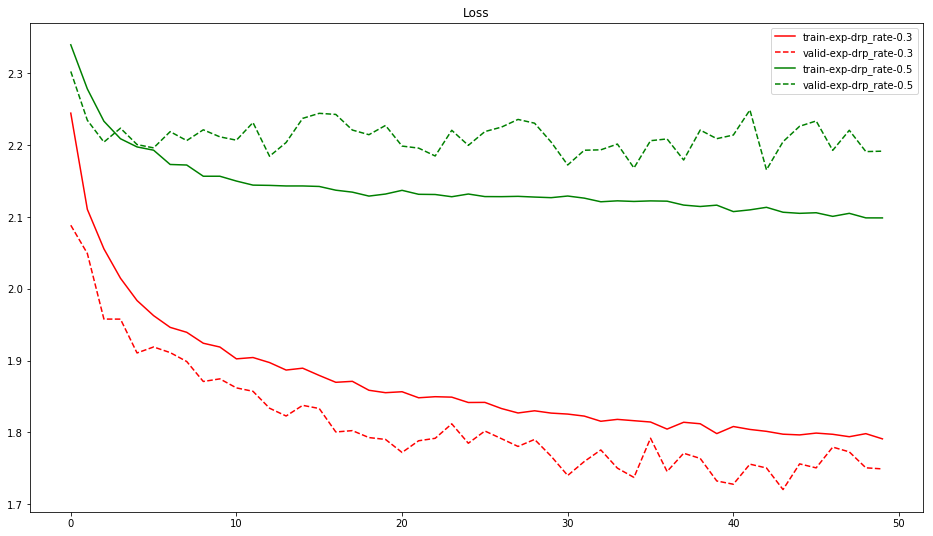

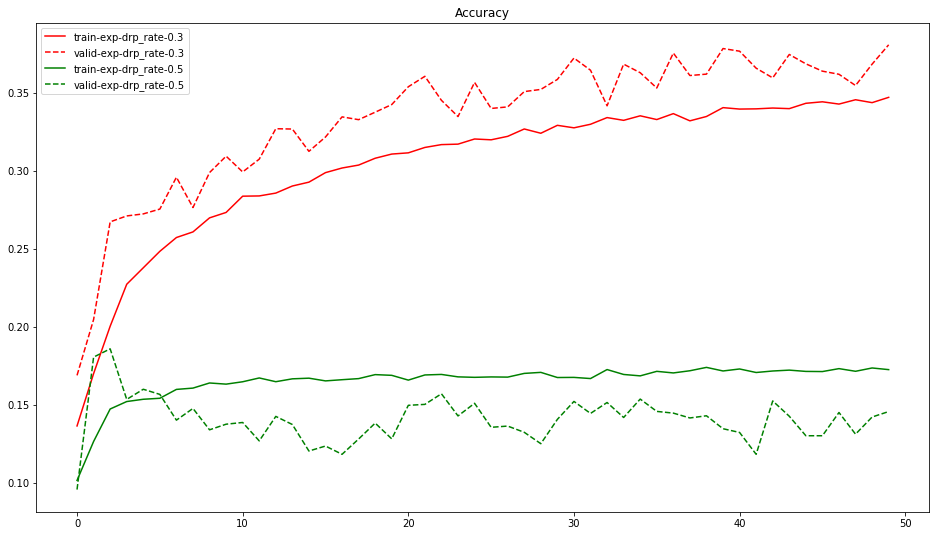

In [13]:
plt_model_result(results)